# Sialorrhea  Analysis
## Part1: analysis with mouth features
Read Files

In [1]:
#read csv files for getting the data
import csv
import os
import sys
import pandas as pd
import numpy as np

#read the csv file
def read_csv_features(file):
    df = pd.read_csv(file)
    df['user'] = df['0'].str.split('_').str[0]  
    df['user'] = df['user'].str.split('.').str[0]
    df = df.drop(columns=['0'])  
    #remove rows with same user
    df.set_index('user', inplace=True)
    df = df[~df.index.duplicated(keep='first')]
    return df
happpy_csv = '\\\\files.ubc.ca\\team\\PPRC\\Camera\\Video Assessment_Atefeh\\sialorrhea\\all_features_10_max_happiness_2.csv'
happy_df = read_csv_features(happpy_csv)
#read the csv file
neutral_csv = '\\\\files.ubc.ca\\team\\PPRC\\Camera\\Video Assessment_Atefeh\\sialorrhea\\all_features_10_true_neutral_2.csv'
neutral_df = read_csv_features(neutral_csv)

FileNotFoundError: [Errno 2] No such file or directory: '\\\\files.ubc.ca\\team\\PPRC\\Camera\\Video Assessment_Atefeh\\sialorrhea\\features_10_max_happiness_2.csv'

In [2]:
sialorreha_csv = '\\\\files.ubc.ca\\team\\PPRC\\Camera\\Video Assessment_Atefeh\\sialorrhea\\saliva.csv'
map_csv = '\\\\files.ubc.ca\\team\\PPRC\\Camera\\Video Assessment_Atefeh\\sialorrhea\\map_id.csv'
saliva_df = pd.read_csv(sialorreha_csv)
saliva_df.set_index('ID', inplace=True)
map_df = pd.read_csv(map_csv)

saliva_df = saliva_df.join(map_df.set_index('Subjet ID'), on='ID')
#remove nan rows where 'ROMP_saliva_Q_done' is nan
saliva_df = saliva_df.dropna(subset=['ROMP_saliva_Q_done','Booth ID'])   
saliva_df = saliva_df[saliva_df['ROMP_saliva_Q_done'] == 'Y']
saliva_df.set_index('Booth ID', inplace=True)
saliva_df.drop(columns=['ROMP_saliva_Q_done','Date','Unnamed: 13'], inplace=True)
saliva_df.index = saliva_df.index.astype(int).astype(str)


Analysis of correlation between features

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

#correct column name remove after the first dot
saliva_df.columns = saliva_df.columns.str.split('.').str[0]
# Compute the correlation matrix
correlation_matrix = saliva_df.corr()



# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues')
plt.title('Saliva DataFrame Correlation Heatmap')
plt.show()


ModuleNotFoundError: No module named 'seaborn'

In [3]:
def compute_features(df):
    sqrt_of_sums = np.sqrt(df.iloc[:, -2]**2 + df.iloc[:, -1]**2)

    # Divide all features by this value
    df = df.div(sqrt_of_sums, axis=0)

    # Drop the last two features
    df = df.iloc[:, :-2]
    return df

def compute_combined_features(happy_df, neutral_df):
    happy_df = compute_features(happy_df)
    neutral_df = compute_features(neutral_df)

    happy_df = happy_df.add_suffix('_happy')
    neutral_df = neutral_df.add_suffix('_neutral')

    # Combine the two dataframes
    combine_features_df = pd.concat([happy_df, neutral_df], axis=1, join='inner')
    return combine_features_df

combine_features_df = compute_combined_features(happy_df, neutral_df)

# Assuming 'participant_id' in combine_features_df corresponds to 'id' in saliva_df
merged_df = combine_features_df.join(saliva_df, how='inner', rsuffix='_saliva')


In [4]:
#print ids that are not in the merged_df but still are in the saliva_df
ids = saliva_df.index
ids = set(ids)
ids = ids - set(merged_df.index)
print(ids)

{'36660', '18317', '34417', '17980', '39685', '15813', '36564', '38902', '30982', '36581', '38050', '31318', '24860', '33023', '25260', '19091'}


In [7]:
import os
import shutil
for id in ids:
    source = r'N:\Booth_Processed\facial_expression\happy\text\frames'
    destination = r'N:\Video Assessment_Atefeh\sialorrhea\new_merge'
    
    for item in os.listdir(source):
        if os.path.isdir(os.path.join(source, item)) and item.startswith(id+'_'):
            shutil.copytree(os.path.join(source, item), os.path.join(destination, item))
            print('Copied directory:', item)



Copied directory: 36660_20231205_facial_expression_happy
Copied directory: 18317_20230919_facial_expression_happy
Copied directory: 34417_20240307_facial_expression_happy
Copied directory: 17980_20240109_facial_expression_happy
Copied directory: 39685_20240307_facial_expression_happy
Copied directory: 15813_20240123_facial_expression_happy
Copied directory: 36564_20240123_facial_expression_happy
Copied directory: 38902_20231204_facial_expression_happy
Copied directory: 30982_20230719_facial_expression_happy
Copied directory: 36581_20231121_facial_expression_happy
Copied directory: 38050_20230918_facial_expression_happy
Copied directory: 31318_20231120_facial_expression_happy
Copied directory: 24860_20231212_facial_expression_happy
Copied directory: 33023_20230719_facial_expression_happy
Copied directory: 25260_20240116_facial_expression_happy
Copied directory: 19091_20231127_facial_expression_happy


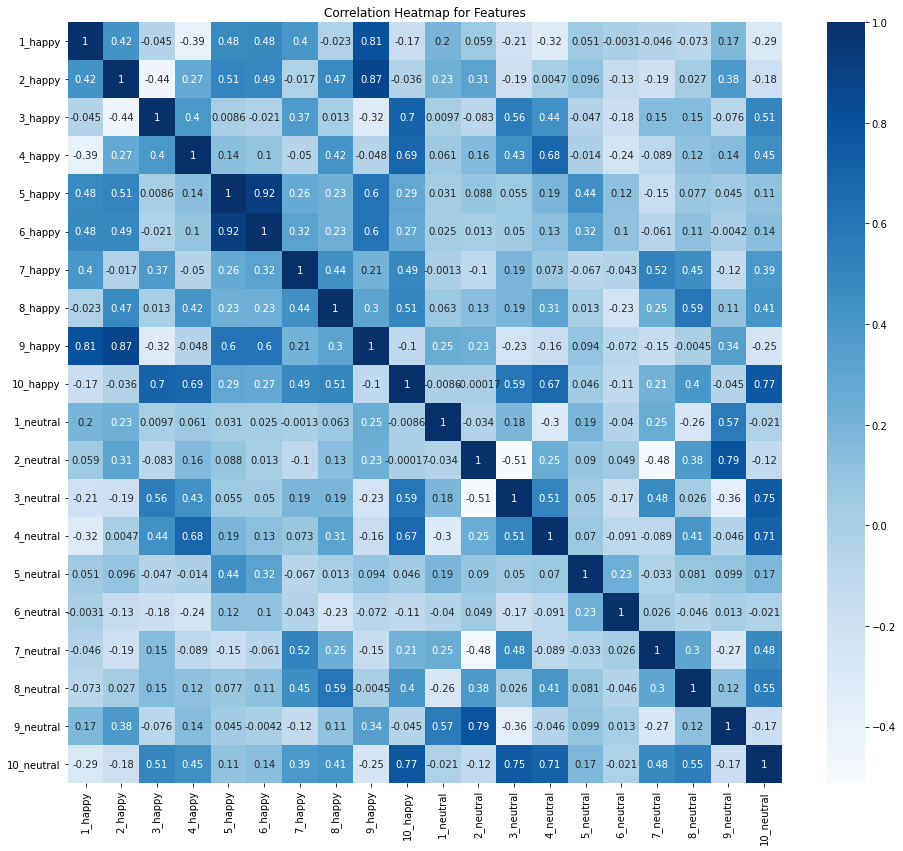

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
correlation_matrix = combine_features_df.corr()

# Create the heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues')
plt.title('Correlation Heatmap for Features')
plt.show()


First CCA with 9 components

In [77]:

import pandas as pd
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler

# Initialize the standard scaler
scaler = StandardScaler()

# Fit and transform the data
Y = scaler.fit_transform(merged_df.iloc[:,-9:])  # Features
X = scaler.fit_transform(merged_df.iloc[:,:-10])  # Questionnaire results

# Initialize CCA with the number of components is the smaller number of columns in the two datasets
n_components = min(saliva_df.shape[1], combine_features_df.shape[1])
n_components=5
cca = CCA(n_components=9)

# Fit CCA
cca.fit(X, Y)

# Transform the data (this step computes the canonical variables)
X_c, Y_c = cca.transform(X, Y)


cca.coef_

array([[ 1.52620962,  1.10171109,  1.15801759,  1.37639262,  0.07703692,
        -0.58241632, -0.34942754, -0.76925876,  1.46942665],
       [ 0.68961028,  1.01929669, -0.02234835,  0.08340456, -0.38090662,
        -0.46267753, -0.35493848, -0.91758838,  0.52415617],
       [-0.74265024, -0.37948256, -0.64139851, -0.67961591,  0.02630147,
         0.16659599,  0.16545203,  0.1798135 , -0.57853054],
       [-0.13786578, -0.30579964,  0.42624205,  0.51862361,  0.40364535,
        -0.07131412,  0.53890479,  0.23822445,  0.36501708],
       [-0.17007244, -0.19040028,  0.37128253,  0.21155871, -0.41183241,
        -0.20211149,  0.41551256,  0.21466668,  0.02212818],
       [ 0.33674371,  0.1959249 , -0.26460679,  0.0883371 ,  0.4414218 ,
         0.24815961, -0.27214665, -0.15822128,  0.24541102],
       [-0.13295755, -0.1351808 , -0.20652327, -0.31077303,  0.08302779,
         0.17533709,  0.17382891,  0.13731552, -0.06092833],
       [-0.13251164, -0.48911109, -0.21021411, -0.2650485 , -0

Pearson t-test between features and questions

In [78]:
import pandas as pd
from scipy.stats import pearsonr


# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Feature', 'Saliva_Column', 'Correlation', 'P-Value'])

# Iterate over each feature in combine_features_df
for feature in combine_features_df.columns:
    # Iterate over each column in saliva_df
    for column in saliva_df.columns:
        # Calculate the Pearson correlation coefficient and the p-value
        correlation, p_value = pearsonr(merged_df[feature], merged_df[column])
        
        # Append the results to the results_df
        results_df = results_df.append({'Feature': feature, 'Saliva_Column': column, 'Correlation': correlation, 'P-Value': p_value}, ignore_index=True)

# Optionally, you can filter the results to only keep significant correlations
significant_results_df = results_df[results_df['P-Value'] < 0.05]

print(significant_results_df)


       Feature Saliva_Column  Correlation   P-Value
10     2_happy            Q1    -0.335568  0.048757
72     8_happy            Q3    -0.399992  0.017275
101  1_neutral            Q2    -0.353099  0.037466
115  2_neutral            Q6    -0.425750  0.010774
117  2_neutral            Q8    -0.358165  0.034632
123  3_neutral            Q4    -0.378708  0.024871
137  4_neutral            Q8    -0.501162  0.002164
165  7_neutral            Q6     0.432273  0.009506
167  7_neutral            Q8     0.368325  0.029474
177  8_neutral            Q8    -0.360733  0.033264


In [79]:
#save significant results to a csv file
significant_results_df.to_csv('significant_results_10feaure.csv', index=False)

Show CCA Coeficients

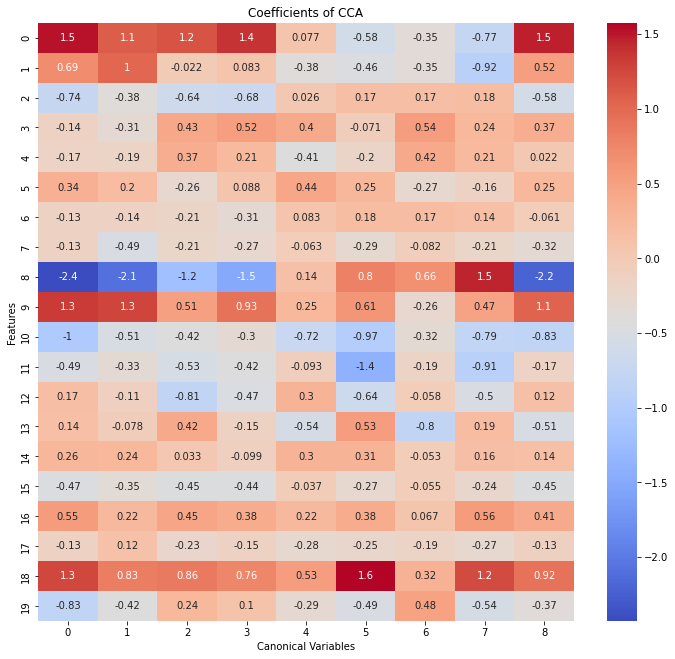

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming cca is your CCA object
plt.figure(figsize=(12, 11))
coefficients = cca.coef_

# Create a heatmap
sns.heatmap(coefficients, cmap='coolwarm', annot=True)

# Add labels and title
plt.xlabel('Canonical Variables')
plt.ylabel('Features')
plt.title('Coefficients of CCA')

# Show the plot
plt.show()


SHow CCA Weights

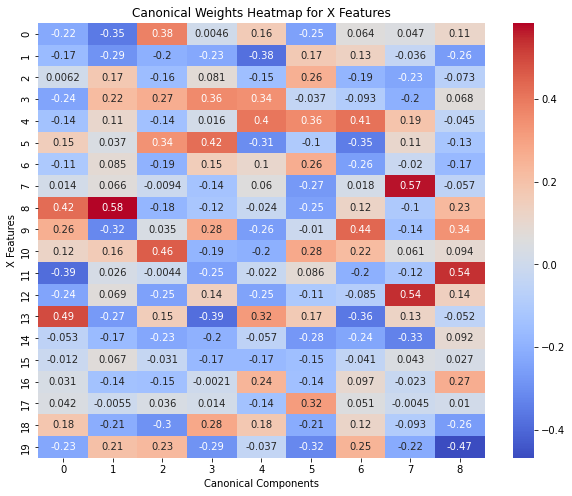

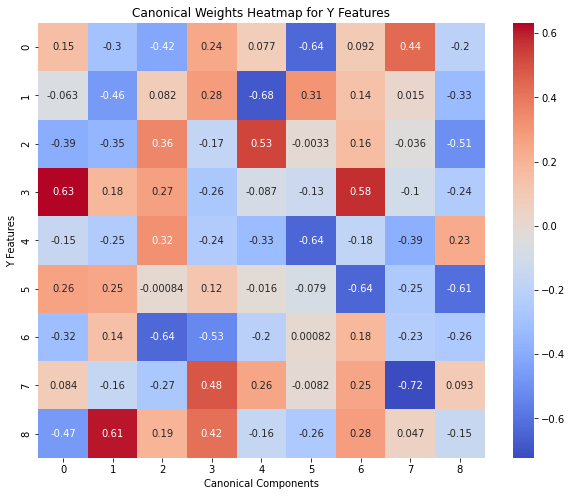

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

weights_X = cca.x_weights_  # Canonical weights for features in X
weights_Y = cca.y_weights_  # Canonical weights for features in Y

# Creating a heatmap for X weights
plt.figure(figsize=(10, 8))
sns.heatmap(weights_X, annot=True, cmap="coolwarm")
plt.title('Canonical Weights Heatmap for X Features')
plt.xlabel('Canonical Components')
plt.ylabel('X Features')
plt.show()

# Repeat similarly for Y weights
plt.figure(figsize=(10, 8))
sns.heatmap(weights_Y, annot=True, cmap="coolwarm")
plt.title('Canonical Weights Heatmap for Y Features')
plt.xlabel('Canonical Components')
plt.ylabel('Y Features')
plt.show()



## Part2: Applying CCA with Cross Validation and bootstrap
The results below clearly demonstrate that there is variation in the coefficients, pointing to a possible issue with either the number of data points, the number of features, or even the number of components.



In [104]:
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA
# Initialize the standard scaler
scaler = StandardScaler()

# Fit and transform the data
Y = scaler.fit_transform(merged_df.iloc[:, -9:])  # Features
X = scaler.fit_transform(merged_df.iloc[:, :-10])  # Questionnaire results

#Apply feature selection
pca = PCA(n_components=0.95)

X = pca.fit_transform(X)

Canonical Correlations for fold: [ 0.58659729 -0.20631577  0.12772264 -0.92087284  0.05764904 -0.3015311
 -0.2750142  -0.72065795 -0.12259148]
Canonical Correlations for fold: [ 0.64884452 -0.29625982 -0.01818491 -0.37058938 -0.31282234  0.25912096
 -0.09742232  0.24939221 -0.09354545]
Canonical Correlations for fold: [ 0.10153216  0.41197719 -0.37718952 -0.65152977 -0.40646858 -0.1641322
 -0.08442522 -0.34181573  0.01858323]
Canonical Correlations for fold: [-0.12980476  0.90702464  0.26874378 -0.12798705 -0.25695555 -0.84854479
 -0.1009686  -0.00112162  0.32224994]
Canonical Correlations for fold: [ 0.15926738  0.74304737 -0.70397438  0.67839895  0.2953525  -0.77463258
  0.02583175  0.55083931 -0.02929553]
Average correlations across folds: [ 0.27328732  0.31189472 -0.14057648 -0.27851602 -0.12464899 -0.36594394
 -0.10639972 -0.05267276  0.01908014]
Standard deviation of correlations across folds: [0.29805703 0.48754134 0.35437554 0.54746402 0.2615226  0.40878187
 0.09644581 0.444507

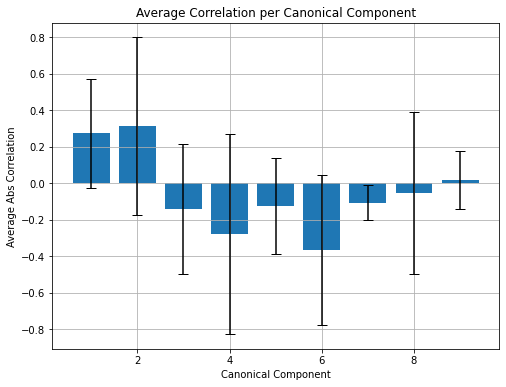

In [82]:
import pandas as pd

from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold
import numpy as np




# Define the number of components for CCA
n_components = min(Y.shape[1], X.shape[1])

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=22)

# To store correlations for each fold
correlations = []

# Cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    # Initialize and fit CCA within the fold
    cca = CCA(n_components=n_components)
    cca.fit(X_train, Y_train)
    
    # Transform the data (this step computes the canonical variables)
    X_c, Y_c = cca.transform(X_test, Y_test)
    
    # Calculate and store the correlation for the current fold
    corr = np.corrcoef(X_c.T, Y_c.T).diagonal(offset=n_components)
    print(f"Canonical Correlations for fold: {corr}")
    correlations.append(corr)

# Aggregate results
average_correlations = np.mean(correlations, axis=0)
print(f"Average correlations across folds: {average_correlations}")

# Optionally, also calculate the standard deviation to estimate variability
std_correlations = np.std(correlations, axis=0)
print(f"Standard deviation of correlations across folds: {std_correlations}")

# Plot the average correlations
plt.figure(figsize=(8, 6))
# plot bar plot with error bars
plt.bar(range(1, n_components+1), average_correlations, yerr=std_correlations, capsize=5)
plt.xlabel('Canonical Component')
plt.ylabel('Average Abs Correlation')
plt.title('Average Correlation per Canonical Component')
plt.grid(True)

### Using Bootstrap and compare loadings


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:107: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:107: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


Average correlations across bootstrap samples: [0.97184592 0.92095052 0.82729918 0.70555464 0.56638816]
Standard deviation of correlations across bootstrap samples: [0.02190486 0.04731453 0.07548113 0.08884575 0.09610122]


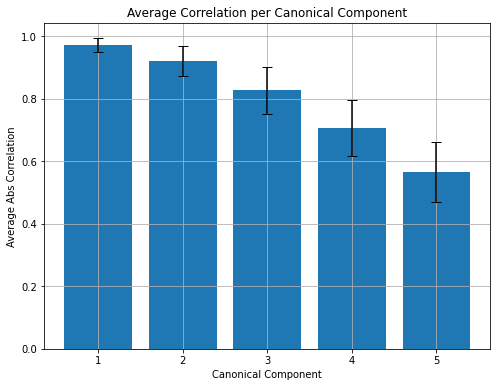

In [83]:
import numpy as np
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample


n_bootstraps = 1000
n_components = 5

def bootstrap_analysis(X,Y, n_components, n_bootstraps):
    # Store bootstrapped loadings
    bootstrapped_loadings_x = np.zeros((n_bootstraps, X.shape[1], n_components))
    bootstrapped_loadings_y = np.zeros((n_bootstraps, Y.shape[1], n_components))

    correlations = []
    for i in range(n_bootstraps):
        # Resample X and Y with replacement
        X_resampled, Y_resampled = resample(X, Y)
        
        # Fit CCA to the resampled data
        cca = CCA(n_components=n_components)
        cca.fit(X_resampled, Y_resampled)
        
        # Store the loadings
        bootstrapped_loadings_x[i] = cca.x_loadings_
        bootstrapped_loadings_y[i] = cca.y_loadings_
        
        # Transform the data (this step computes the canonical variables)
        X_c, Y_c = cca.transform(X_resampled, Y_resampled)
        
        # Calculate and store the correlation for the current fold
        corr = np.corrcoef(X_c.T, Y_c.T).diagonal(offset=n_components)
        correlations.append(corr)

    # Aggregate results
    average_correlations = np.mean(correlations, axis=0)
    print(f"Average correlations across bootstrap samples: {average_correlations}")

    # Optionally, also calculate the standard deviation to estimate variability
    std_correlations = np.std(correlations, axis=0)
    print(f"Standard deviation of correlations across bootstrap samples: {std_correlations}")
    
    return average_correlations, std_correlations

average_correlations, std_correlations = bootstrap_analysis(X,Y,n_components, n_bootstraps)
# Plot the average correlations
plt.figure(figsize=(8, 6))
# plot bar plot with error bars
plt.bar(range(1, n_components+1), average_correlations, yerr=std_correlations, capsize=5)
plt.xlabel('Canonical Component')
plt.ylabel('Average Abs Correlation')
plt.title('Average Correlation per Canonical Component')
plt.grid(True)

In [84]:
#Plot reasults
import seaborn as sns
import matplotlib.pyplot as plt

def show_loadings(loadings_x ,loadings_y):
    # Assuming mean_loadings_x is a numpy array of shape (n_components, n_variables)
    mean_loadings_x = loadings_x

    # Create a heatmap
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(mean_loadings_x, annot=True, cmap='viridis',
                    xticklabels=[f'Component {x+1}' for x in range(mean_loadings_x.shape[1])],
                    yticklabels=[f'PC {i+1}' for i in range(mean_loadings_x.shape[0])])

    ax.set_title('Heatmap of Loadings for X Variables')
    plt.xlabel('PC Components')
    plt.ylabel('Components')
    plt.show()

    #plot the heatmap for Y variables
    mean_loadings_y = loadings_y
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(mean_loadings_y, annot=True, cmap='viridis',
                    xticklabels=[f'Component {y+1}' for y in range(mean_loadings_y.shape[1])],
                    yticklabels=[f'Question {i+1}' for i in range(mean_loadings_y.shape[0])])

    ax.set_title('Heatmap of Loadings for Y Variables')
    plt.xlabel('Variables')
    plt.ylabel('Components')
    plt.show()


-0.5617152290271833


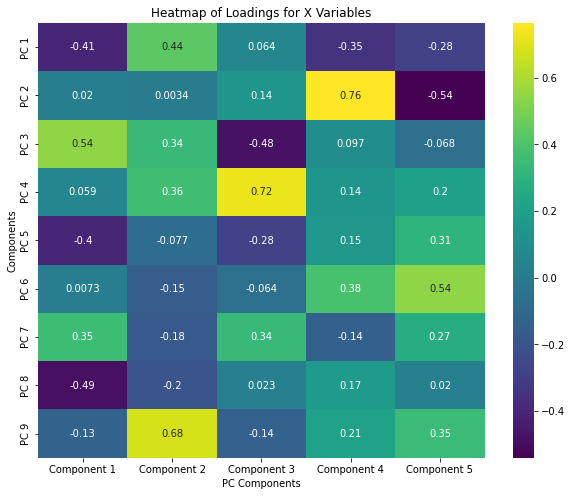

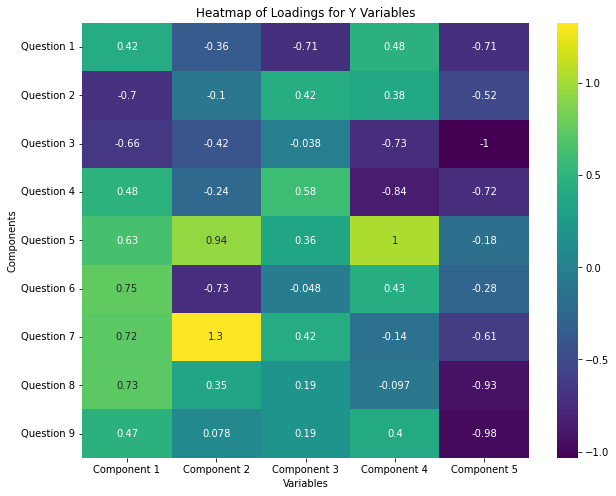

In [113]:
# Fit CCA on the entire dataset using the average number of components
cca = CCA(n_components=5)
cca.fit(X, Y)

# Transform the data to get canonical variables
X_c, Y_c = cca.transform(X, Y)

#print cca score
print(cca.score(X,Y))
show_loadings(cca.x_loadings_, cca.y_loadings_)


# Scatter plots of commponents

Correlation for pair 1: 0.908758407764574, P-value: 4.507515352576822e-14


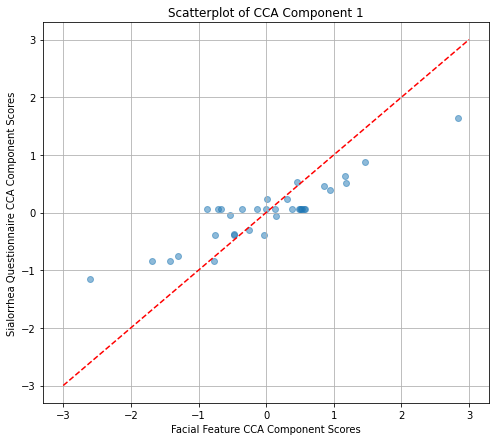

Correlation for pair 2: 0.8345035607733831, P-value: 4.685697202986278e-10


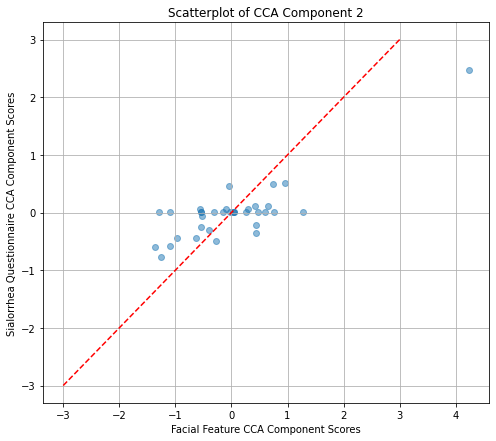

Correlation for pair 3: 0.6396155662506651, P-value: 3.522997712098773e-05


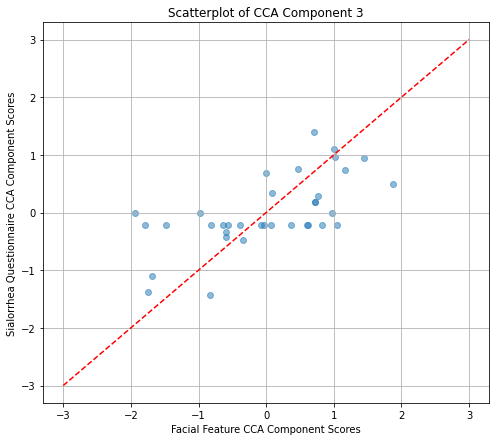

Correlation for pair 4: 0.5035433650555365, P-value: 0.0020448826320592674


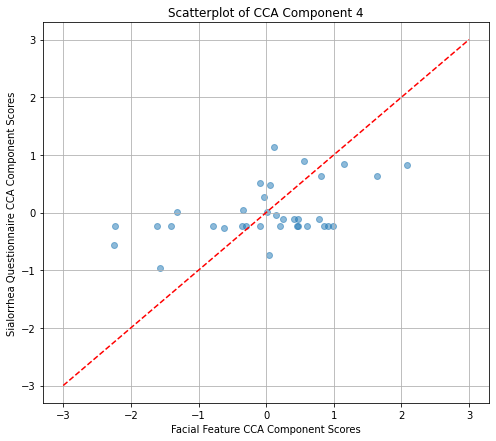

Correlation for pair 5: 0.36408394395250354, P-value: 0.03154471411934946


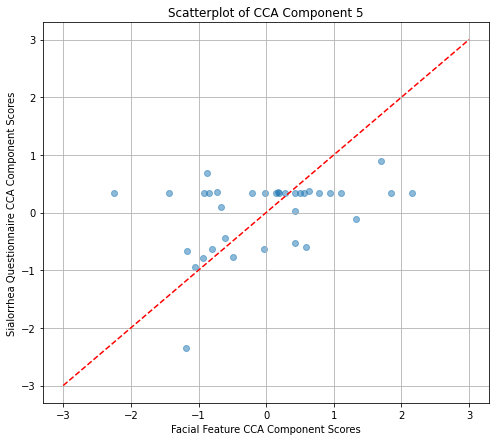

In [106]:
import matplotlib.pyplot as plt

# Number of components to plot
n_components_to_plot = X_c.shape[1]

for i in range(n_components_to_plot):
    corr, p_value = pearsonr(X_c[:, i], Y_c[:, i])
    print(f"Correlation for pair {i+1}: {corr}, P-value: {p_value}")
    plt.figure(figsize=(8,7))
    plt.scatter(X_c[:, i], Y_c[:, i], alpha=0.5)
    #plot x=y line
    plt.plot(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100), color='red', linestyle='--')
    plt.title(f'Scatterplot of CCA Component {i+1}')
    plt.xlabel('Facial Feature CCA Component Scores')
    plt.ylabel('Sialorrhea Questionnaire CCA Component Scores')
    plt.grid(True)
    plt.show()


CCA Weights

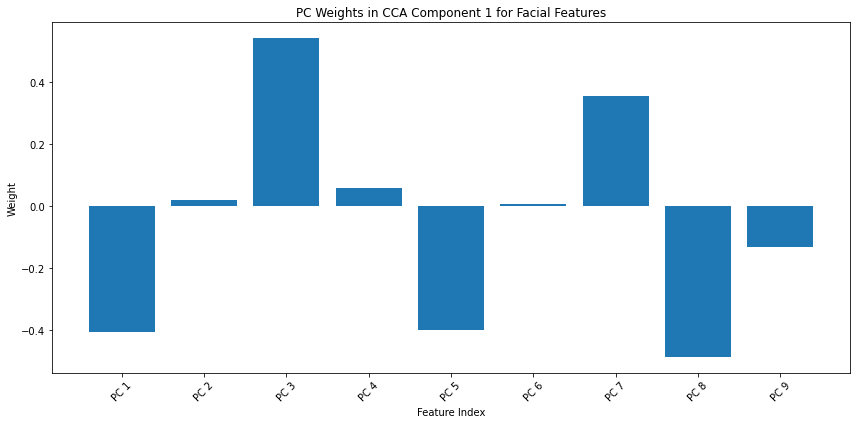

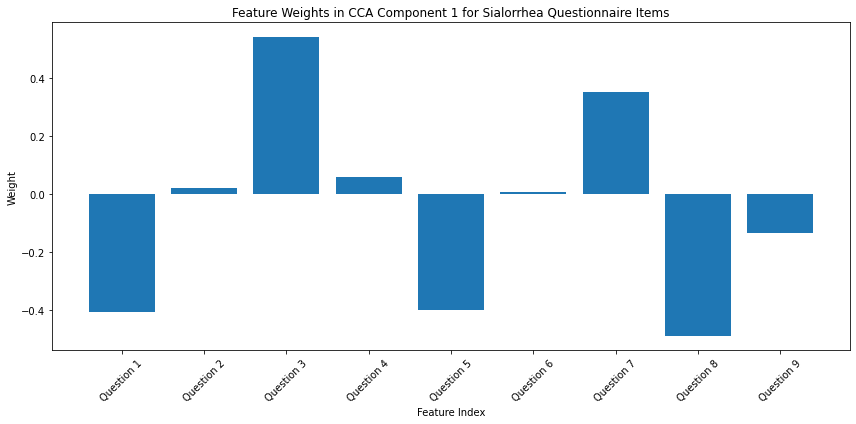

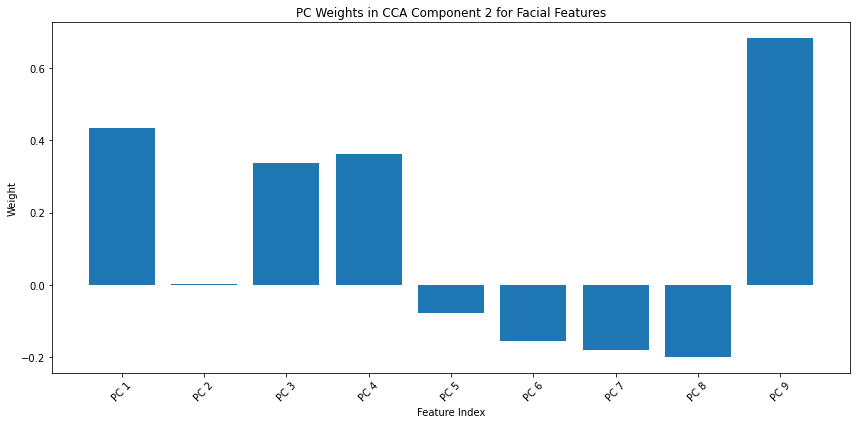

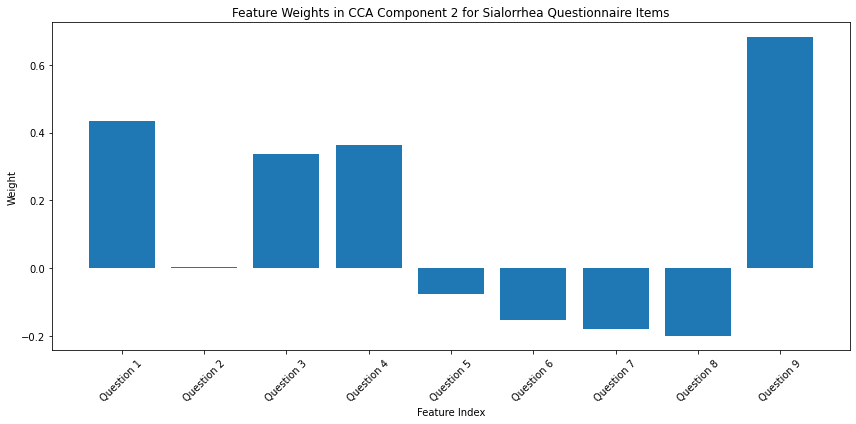

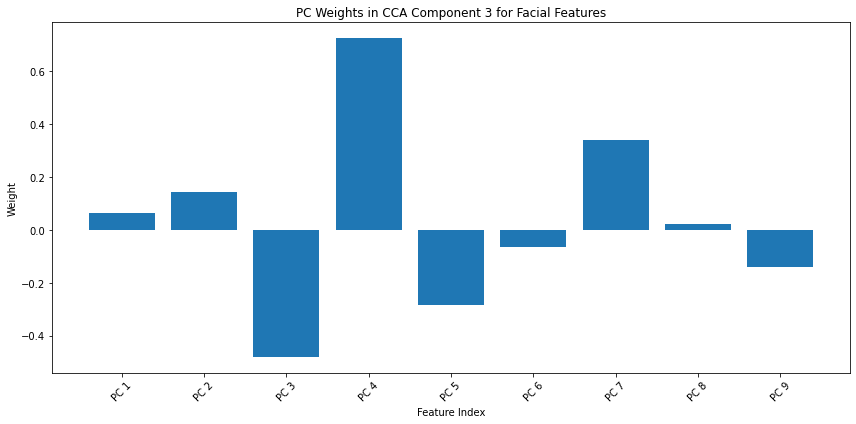

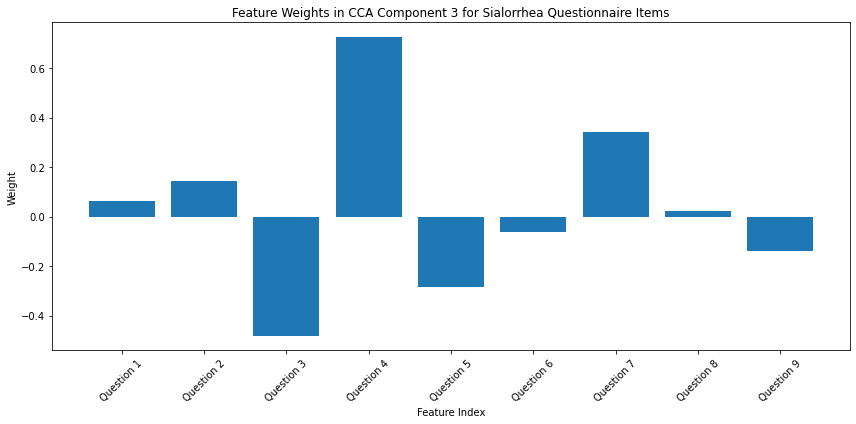

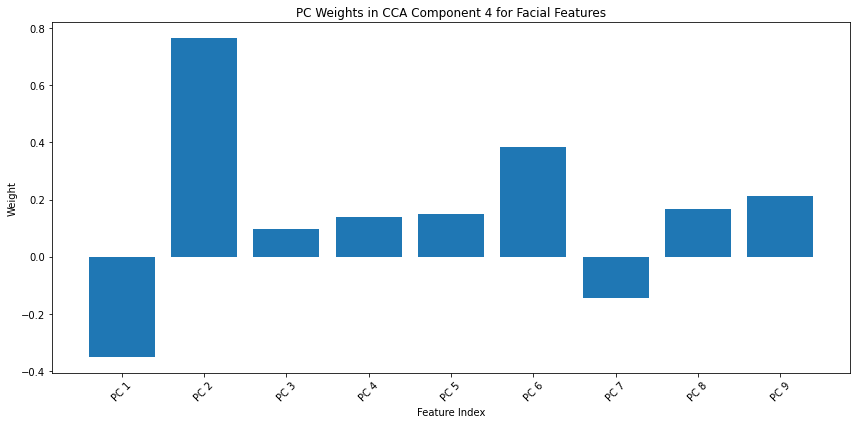

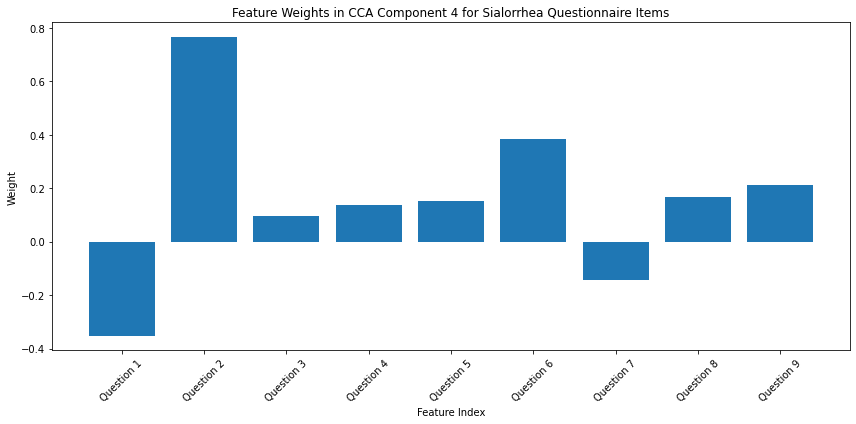

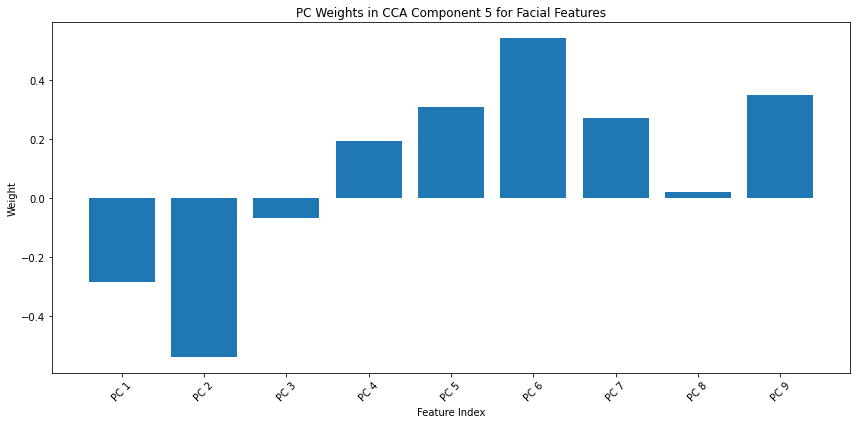

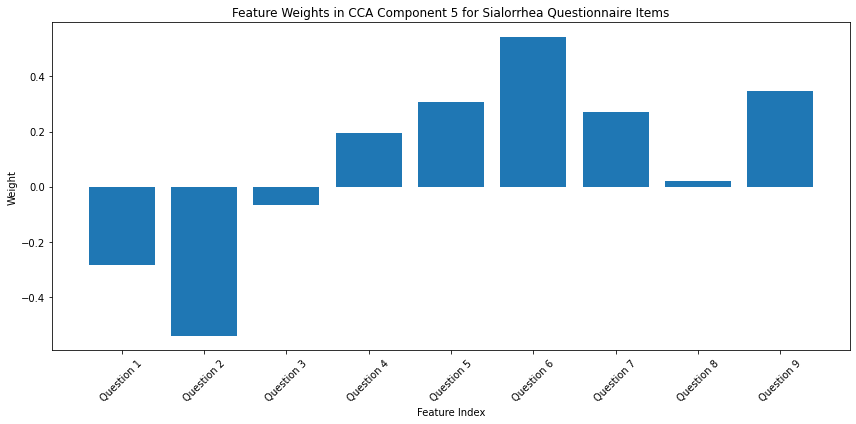

In [114]:
#The left and right singular vectors of the cross-covariance matrices of X and Y
import matplotlib.pyplot as plt


for component_index in range(n_components_to_plot):
    # Extracting weights for the component
    weights_x = cca.x_weights_[:, component_index]
    weights_y = cca.x_weights_[:, component_index]

    # Plotting for X features
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(weights_x)), weights_x)
    plt.title(f'PC Weights in CCA Component {component_index+1} for Facial Features')
    plt.xlabel('Feature Index')
    plt.ylabel('Weight')
    plt.xticks(range(len(weights_x)), [f'PC {i+1}' for i in range(len(weights_x))], rotation=45)
    plt.tight_layout()
    plt.show()

    # Plotting for Y features
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(weights_y)), weights_y)
    plt.title(f'Feature Weights in CCA Component {component_index+1} for Sialorrhea Questionnaire Items')
    plt.xlabel('Feature Index')
    plt.ylabel('Weight')
    plt.xticks(range(len(weights_y)), [f'Question {i+1}' for i in range(len(weights_y))], rotation=45)
    plt.tight_layout()
    plt.show()



### Analysis PCA Components

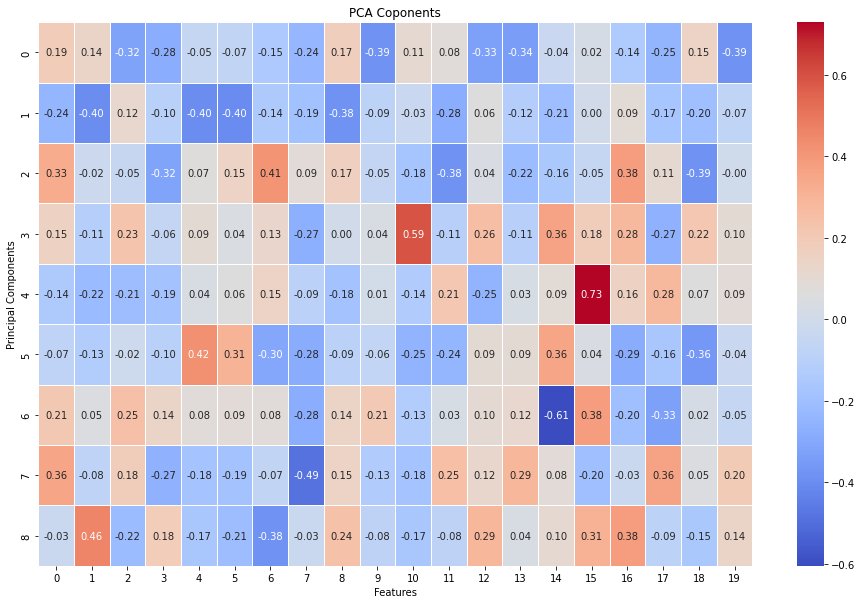

In [88]:
# Magnitude: A higher absolute value of a loading indicates that the variable strongly influences the principal component.
# Sign: The sign (positive or negative) indicates the direction of the influence. Variables with the same sign in a PC are directly related, while those with opposite signs are inversely related.

import seaborn as sns
#Evaluate PCA

import matplotlib.pyplot as plt

# Get the PCA loadings
pca_loadings = pca.components_

# Create a heatmap of the PCA loadings
plt.figure(figsize=(16, 10))
sns.heatmap(pca_loadings, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title('PCA Coponents')
plt.xlabel('Features')
plt.ylabel('Principal Components')
plt.show()


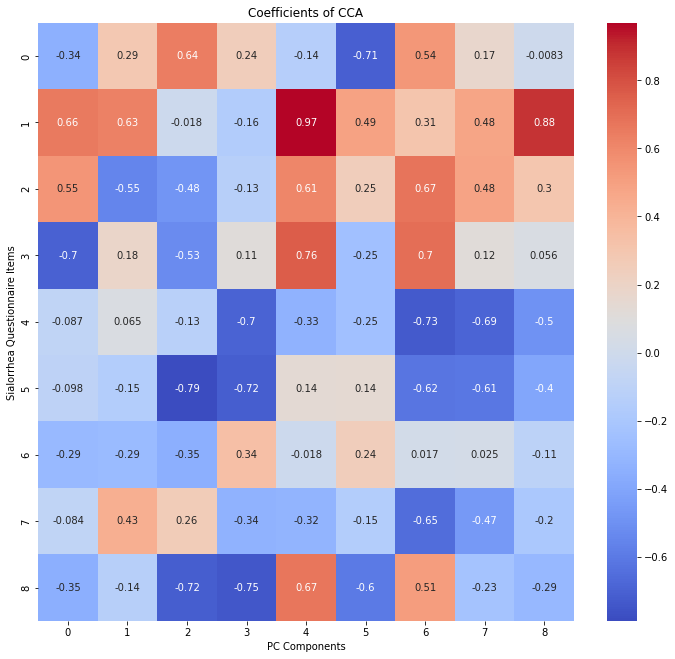

In [89]:
#The coefficients of the linear model such that Y is approximated as Y = X @ coef_.T + b.
# cca coeeficients
plt.figure(figsize=(12, 11))
coefficients = cca.coef_

# Create a heatmap
sns.heatmap(coefficients, cmap='coolwarm', annot=True)

# Add labels and title
plt.xlabel('PC Components')
plt.ylabel('Sialorrhea Questionnaire Items')
plt.title('Coefficients of CCA')

# Show the plot
plt.show()

## Part3: Try with Eye features


In [117]:
eye_features_csv = '\\\\files.ubc.ca\\team\\PPRC\\Camera\\Video Assessment_Atefeh\\sialorrhea\\eye_features_10_true_neutral.csv'
eye_neutral_df = read_csv_features(eye_features_csv)
eye_features_csv = '\\\\files.ubc.ca\\team\\PPRC\\Camera\\Video Assessment_Atefeh\\sialorrhea\\eye_features_10_max_happiness.csv'
eye_happy_df = read_csv_features(eye_features_csv)
combine_eye_features_df = compute_combined_features(eye_happy_df, eye_neutral_df)
# Assuming 'participant_id' in combine_features_df corresponds to 'id' in saliva_df
merged_eye_df = combine_eye_features_df.join(saliva_df, how='inner', rsuffix='_saliva')

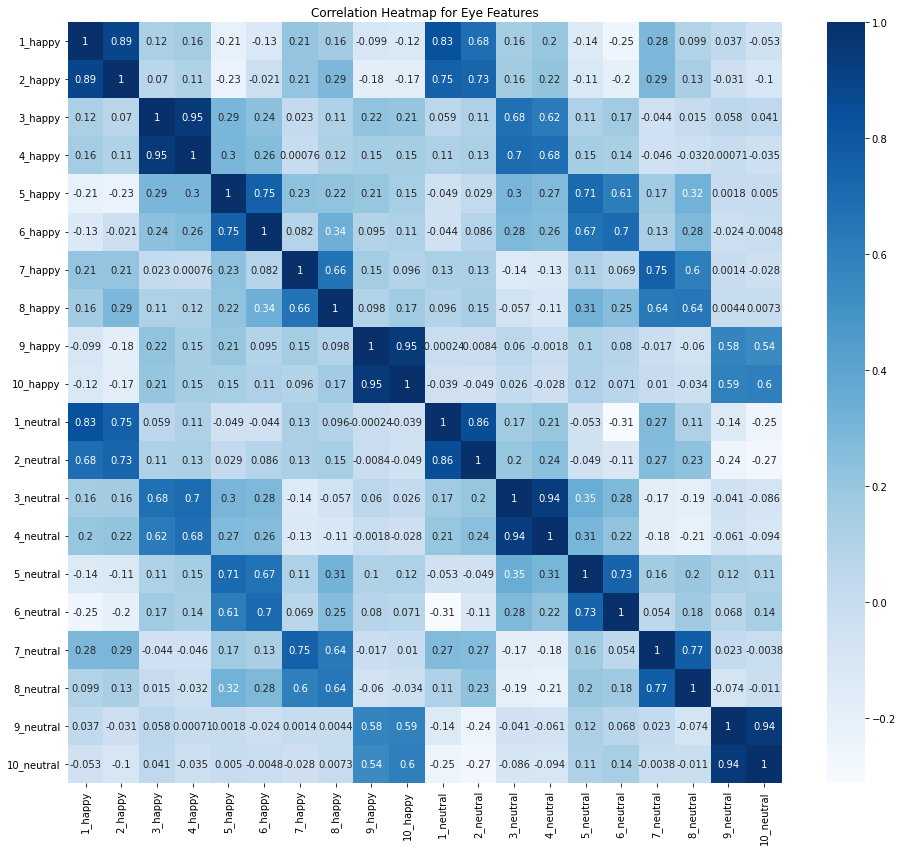

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
correlation_matrix = combine_eye_features_df.corr()

# Create the heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues')
plt.title('Correlation Heatmap for Eye Features')
plt.show()

In [119]:
#Define data
# Initialize the standard scaler
scaler = StandardScaler()

# Fit and transform the data
Y = scaler.fit_transform(merged_eye_df.iloc[:, -9:])  # Features
X_eye = scaler.fit_transform(merged_eye_df.iloc[:, :-10])  # Questionnaire results

#Apply feature selection
pca_eye = PCA(n_components=0.95)

X_eye = pca_eye.fit_transform(X_eye)

Average correlations across bootstrap samples: [0.96672197 0.91490242 0.83320469 0.73073829 0.60604566]
Standard deviation of correlations across bootstrap samples: [0.02736717 0.04654564 0.07028918 0.08417802 0.09769072]


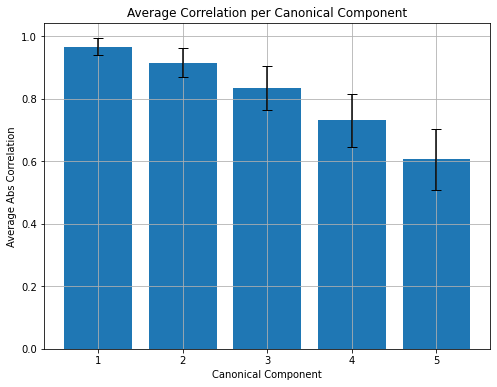

In [120]:
import numpy as np
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample



n_bootstraps = 1000
n_components = 5

average_correlations, std_correlations = bootstrap_analysis(X_eye,Y,n_components, n_bootstraps)
# Plot the average correlations
plt.figure(figsize=(8, 6))
# plot bar plot with error bars
plt.bar(range(1, n_components+1), average_correlations, yerr=std_correlations, capsize=5)
plt.xlabel('Canonical Component')
plt.ylabel('Average Abs Correlation')
plt.title('Average Correlation per Canonical Component')
plt.grid(True)

In [121]:
# Fit CCA on the entire dataset using the average number of components
cca = CCA(n_components=5)
cca.fit(X_eye, Y)

# Transform the data to get canonical variables
X_c, Y_c = cca.transform(X_eye, Y)

Correlation for pair 1: 0.8167900740776546, P-value: 2.180085295123752e-09


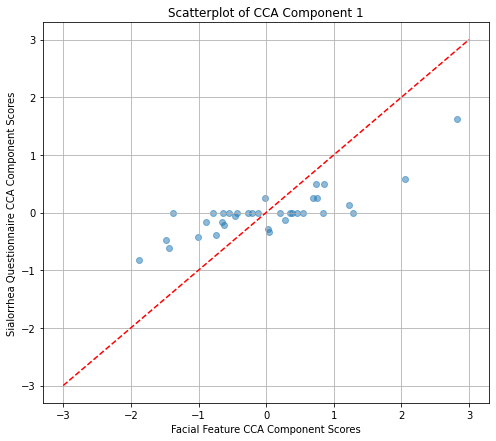

Correlation for pair 2: 0.8083904748845417, P-value: 4.271843487588314e-09


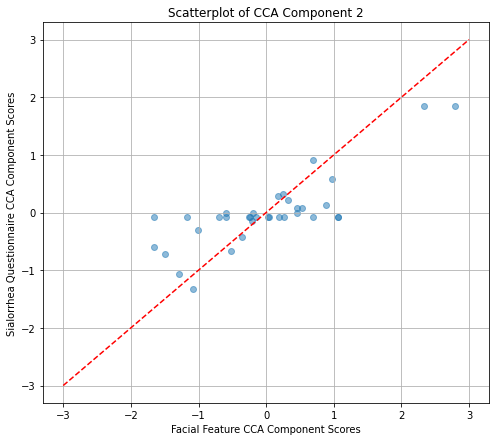

Correlation for pair 3: 0.6280680416985458, P-value: 5.360902809693901e-05


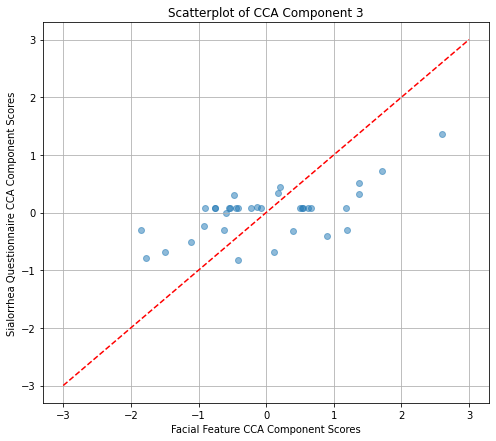

Correlation for pair 4: 0.5713007527530474, P-value: 0.00033772760630926247


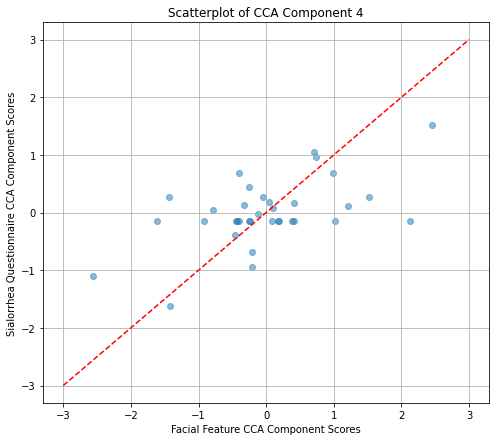

Correlation for pair 5: 0.5238086222556949, P-value: 0.0012405224482236082


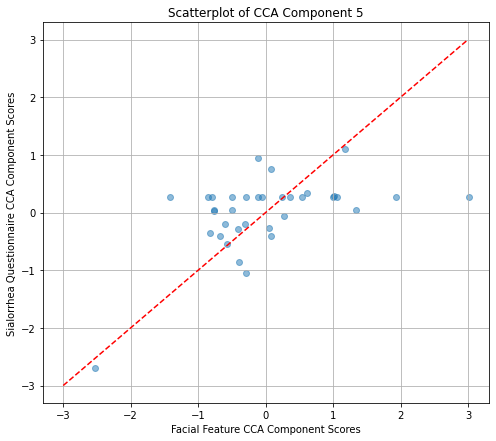

In [122]:
import matplotlib.pyplot as plt

# Number of components to plot
n_components_to_plot = X_c.shape[1]

for i in range(n_components_to_plot):
    corr, p_value = pearsonr(X_c[:, i], Y_c[:, i])
    print(f"Correlation for pair {i+1}: {corr}, P-value: {p_value}")
    plt.figure(figsize=(8,7))
    plt.scatter(X_c[:, i], Y_c[:, i], alpha=0.5)
    #plot x=y line
    plt.plot(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100), color='red', linestyle='--')
    plt.title(f'Scatterplot of CCA Component {i+1}')
    plt.xlabel('Facial Feature CCA Component Scores')
    plt.ylabel('Sialorrhea Questionnaire CCA Component Scores')
    plt.grid(True)
    plt.show()

CCA Score: -0.6824902756422131


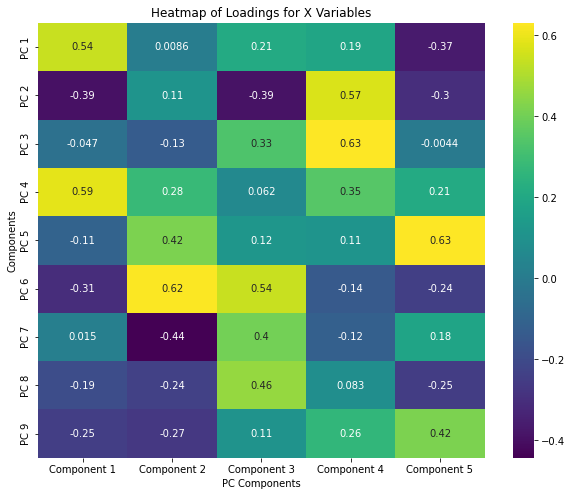

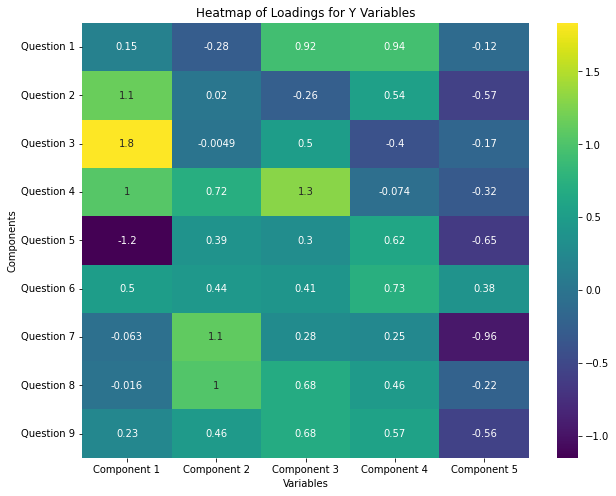

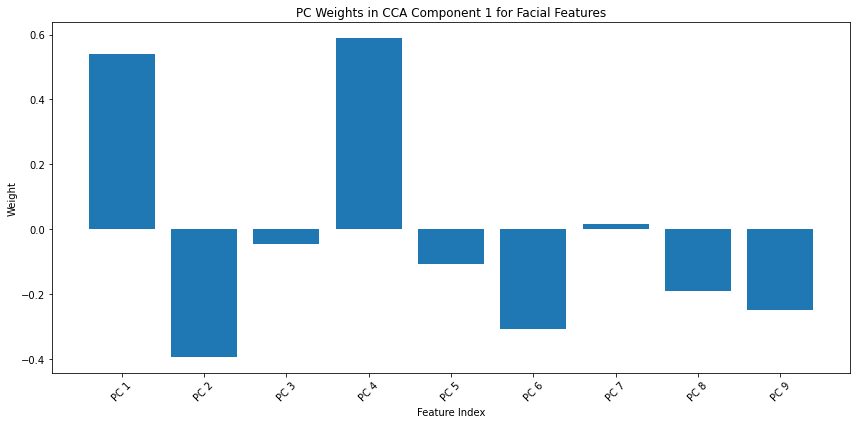

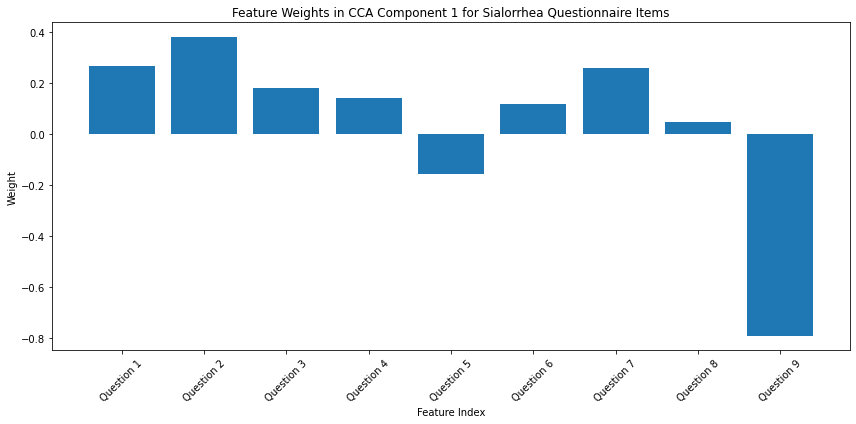

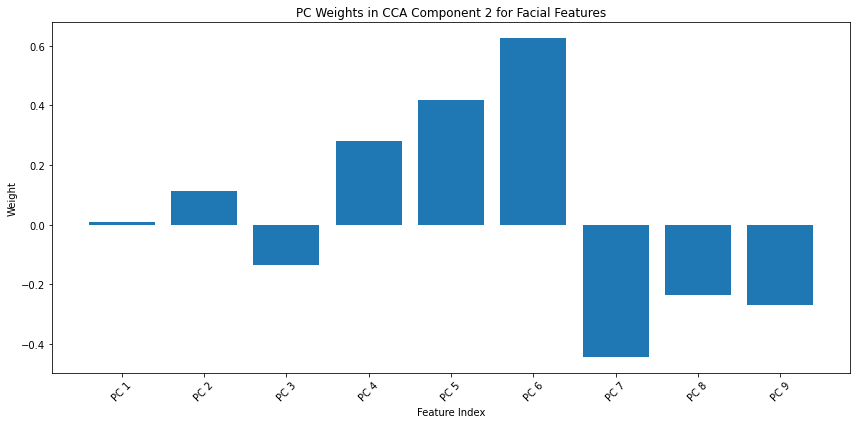

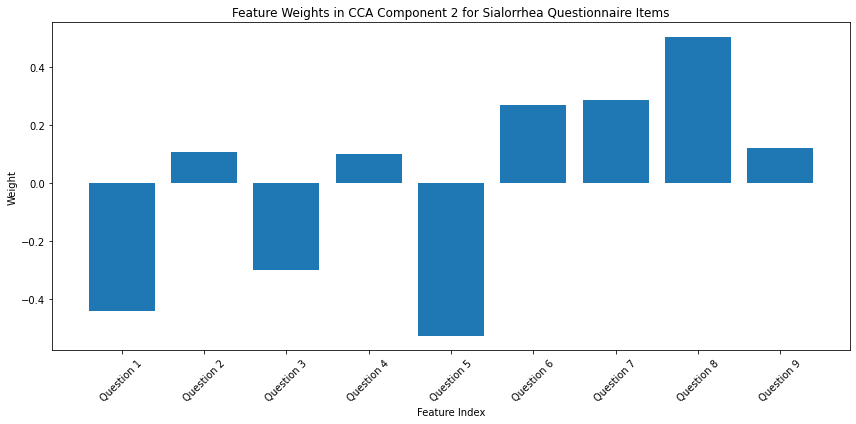

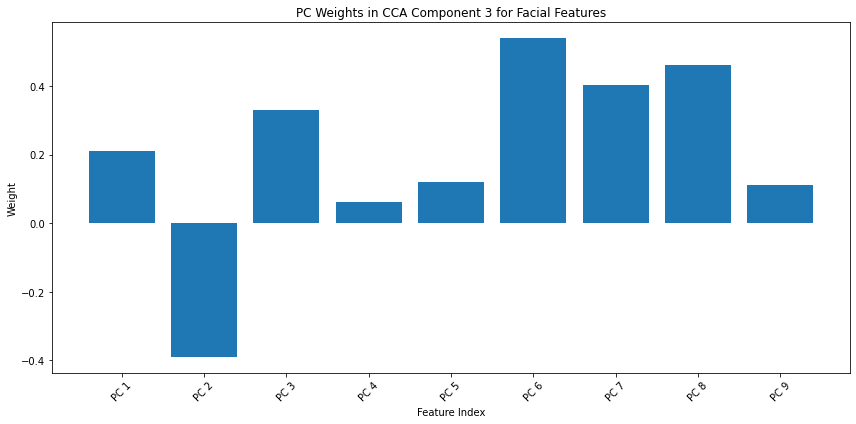

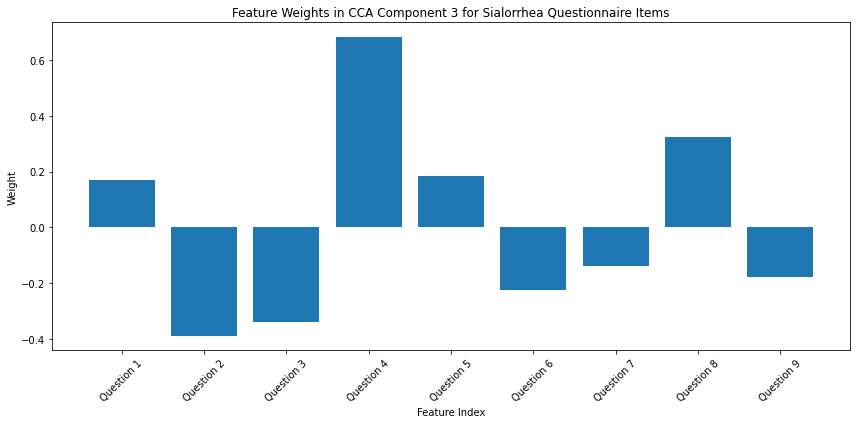

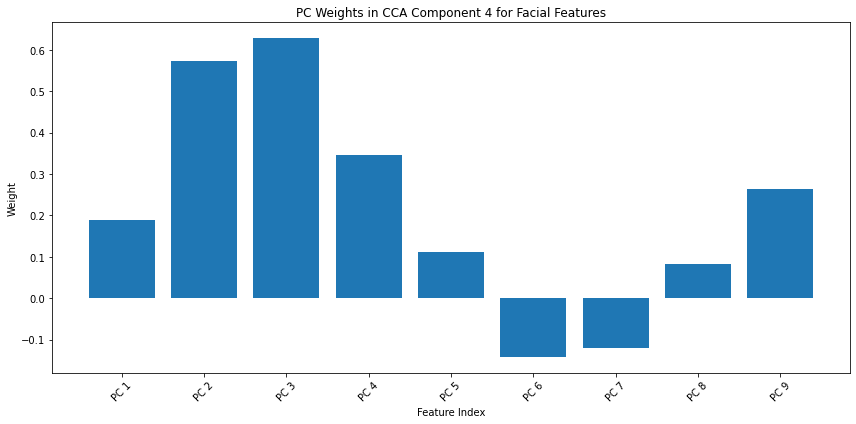

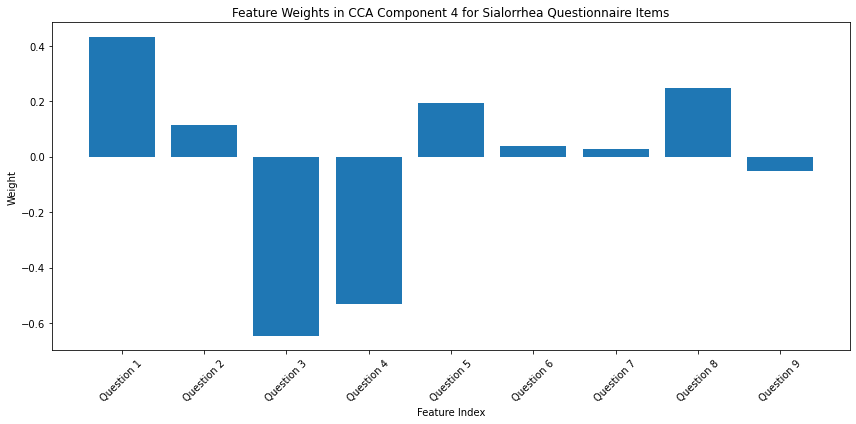

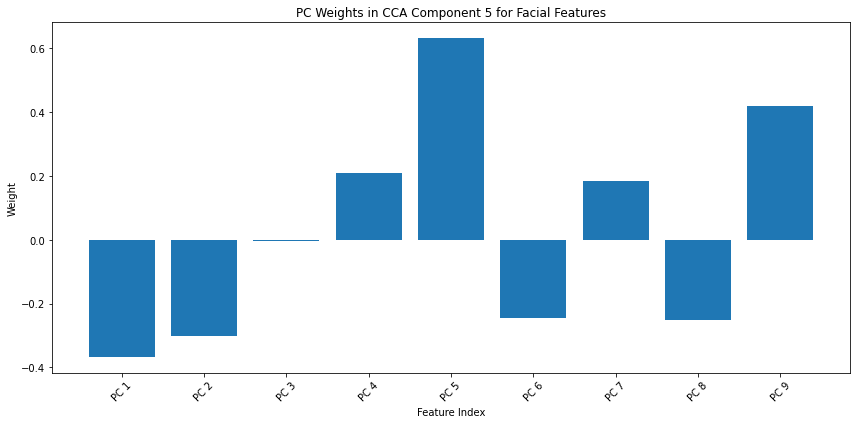

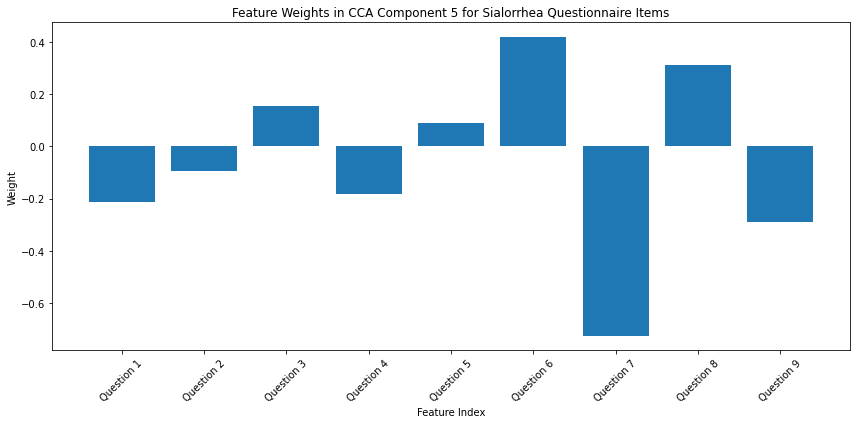

In [124]:
#print cca score
print(f'CCA Score: {cca.score( X_eye, Y)}')
show_loadings(cca.x_loadings_, cca.y_loadings_)

#The left and right singular vectors of the cross-covariance matrices of X and Y
import matplotlib.pyplot as plt


for component_index in range(n_components_to_plot):
    # Extracting weights for the component
    weights_x = cca.x_weights_[:, component_index]
    weights_y = cca.y_weights_[:, component_index]

    # Plotting for X features
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(weights_x)), weights_x)
    plt.title(f'PC Weights in CCA Component {component_index+1} for Facial Features')
    plt.xlabel('Feature Index')
    plt.ylabel('Weight')
    plt.xticks(range(len(weights_x)), [f'PC {i+1}' for i in range(len(weights_x))], rotation=45)
    plt.tight_layout()
    plt.show()

    # Plotting for Y features
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(weights_y)), weights_y)
    plt.title(f'Feature Weights in CCA Component {component_index+1} for Sialorrhea Questionnaire Items')
    plt.xlabel('Feature Index')
    plt.ylabel('Weight')
    plt.xticks(range(len(weights_y)), [f'Question {i+1}' for i in range(len(weights_y))], rotation=45)
    plt.tight_layout()
    plt.show()

## Part4: Analysis of all features (mouth, nose, eyes)

In [125]:
all_features_csv = '\\\\files.ubc.ca\\team\\PPRC\\Camera\\Video Assessment_Atefeh\\sialorrhea\\all_features_10_true_neutral.csv'
all_neutral_df = read_csv_features(all_features_csv)
all_features_csv = '\\\\files.ubc.ca\\team\\PPRC\\Camera\\Video Assessment_Atefeh\\sialorrhea\\all_features_10_max_happiness.csv'
all_happy_df = read_csv_features(all_features_csv)
combine_all_features_df = compute_combined_features(all_happy_df, all_neutral_df)
# Assuming 'participant_id' in combine_features_df corresponds to 'id' in saliva_df
merged_all_df = combine_all_features_df.join(saliva_df, how='inner', rsuffix='_saliva')

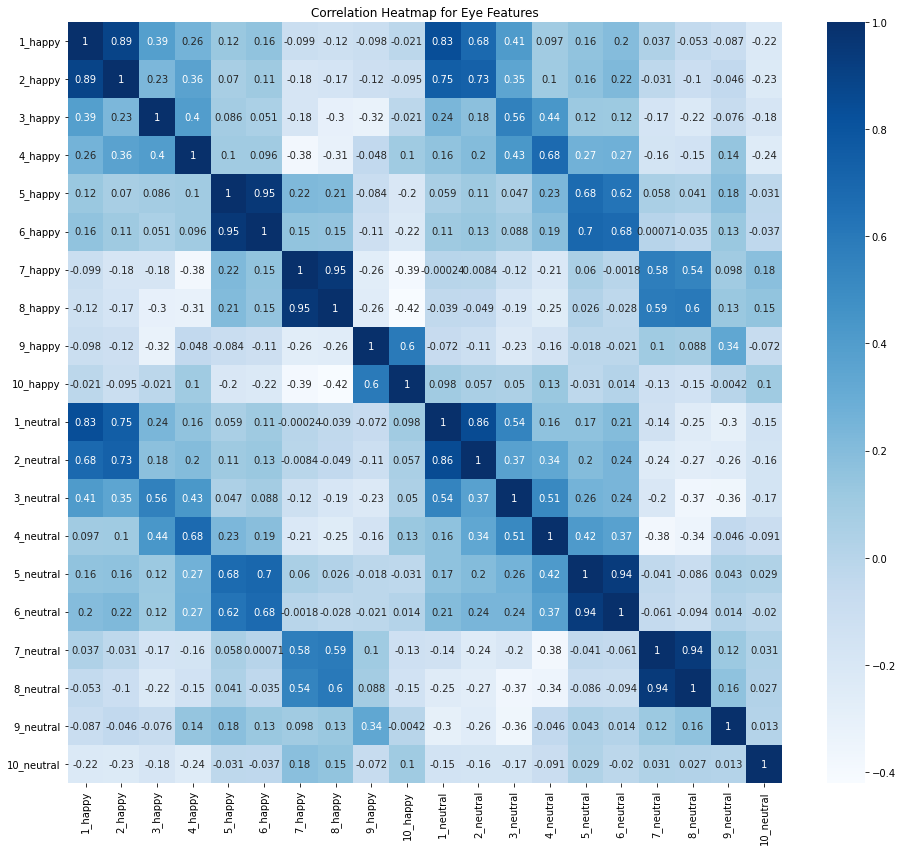

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
correlation_matrix = combine_all_features_df.corr()

# Create the heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues')
plt.title('Correlation Heatmap for Eye Features')
plt.show()

In [128]:
#Define data
# Initialize the standard scaler
scaler = StandardScaler()

# Fit and transform the data
Y = scaler.fit_transform(merged_all_df.iloc[:, -9:])  # Features
X_all = scaler.fit_transform(merged_all_df.iloc[:, :-10])  # Questionnaire results

#Apply feature selection
pca_all = PCA(n_components=0.95)

X_all = pca_all.fit_transform(X_eye)

Average correlations across bootstrap samples: [0.92842184 0.83601591 0.70607315 0.56718027 0.39622519]
Standard deviation of correlations across bootstrap samples: [0.03921655 0.06545463 0.08435004 0.09327378 0.10640581]


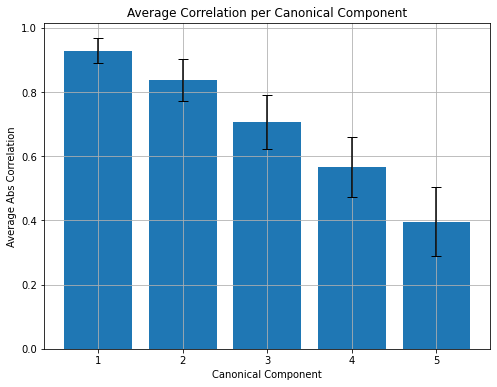

In [129]:
import numpy as np
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample



n_bootstraps = 1000
n_components = 5

average_correlations, std_correlations = bootstrap_analysis(X_all,Y,n_components, n_bootstraps)
# Plot the average correlations
plt.figure(figsize=(8, 6))
# plot bar plot with error bars
plt.bar(range(1, n_components+1), average_correlations, yerr=std_correlations, capsize=5)
plt.xlabel('Canonical Component')
plt.ylabel('Average Abs Correlation')
plt.title('Average Correlation per Canonical Component')
plt.grid(True)

In [131]:
# Fit CCA on the entire dataset using the average number of components
cca = CCA(n_components=5)
cca.fit(X_all, Y)

# Transform the data to get canonical variables
X_c, Y_c = cca.transform(X_all, Y)

Correlation for pair 1: 0.7961843768055789, P-value: 1.0731994441211258e-08


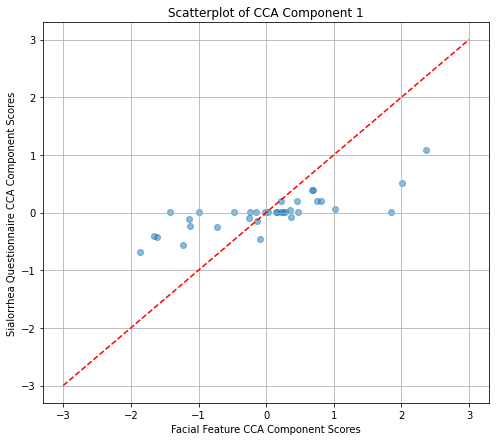

Correlation for pair 2: 0.7307102062338242, P-value: 6.233310460265773e-07


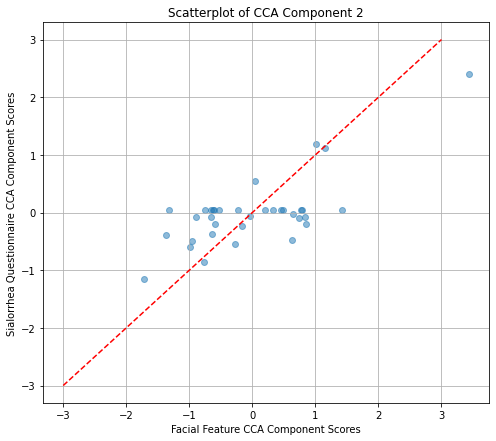

Correlation for pair 3: 0.5542284104616855, P-value: 0.0005513308914720872


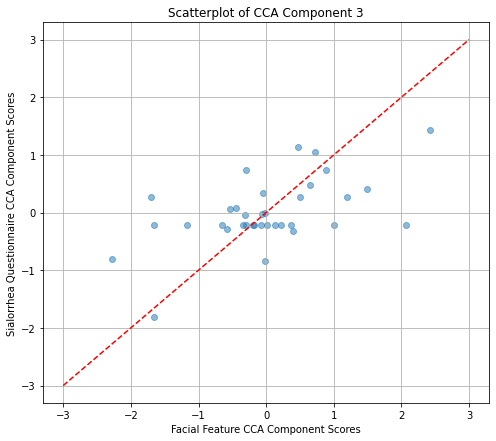

Correlation for pair 4: 0.46219790467771166, P-value: 0.005184719898180953


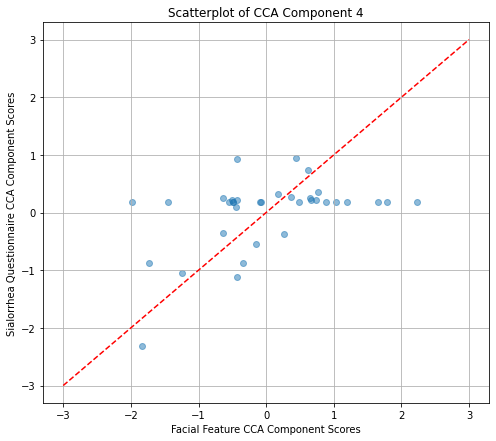

Correlation for pair 5: 0.44000466550249256, P-value: 0.008168660238721072


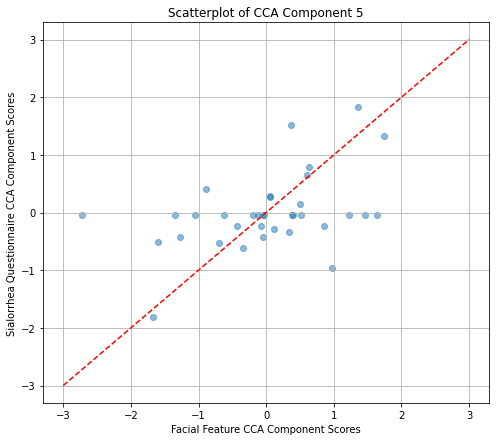

In [132]:
import matplotlib.pyplot as plt

# Number of components to plot
n_components_to_plot = X_c.shape[1]

for i in range(n_components_to_plot):
    corr, p_value = pearsonr(X_c[:, i], Y_c[:, i])
    print(f"Correlation for pair {i+1}: {corr}, P-value: {p_value}")
    plt.figure(figsize=(8,7))
    plt.scatter(X_c[:, i], Y_c[:, i], alpha=0.5)
    #plot x=y line
    plt.plot(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100), color='red', linestyle='--')
    plt.title(f'Scatterplot of CCA Component {i+1}')
    plt.xlabel('Facial Feature CCA Component Scores')
    plt.ylabel('Sialorrhea Questionnaire CCA Component Scores')
    plt.grid(True)
    plt.show()

CCA Score: -0.9215253778247597


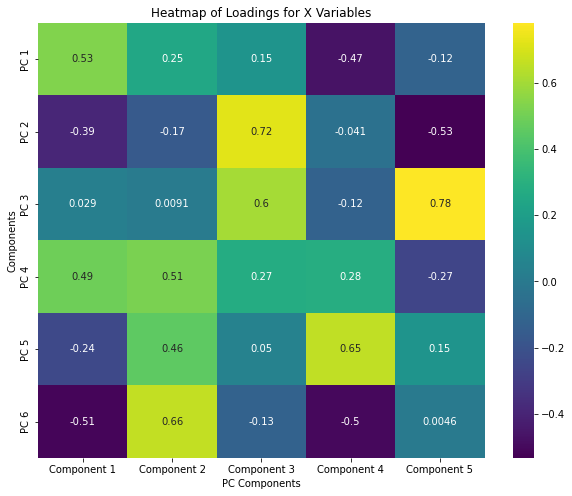

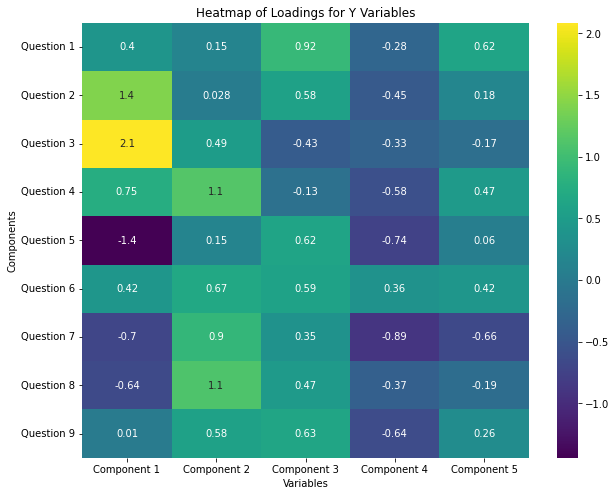

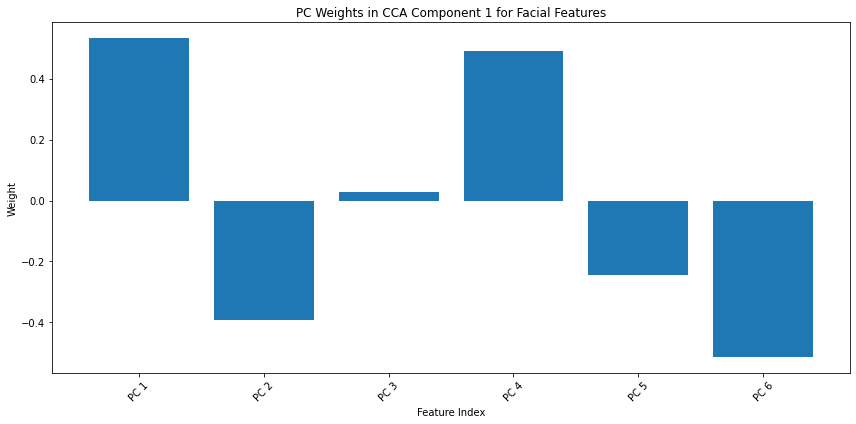

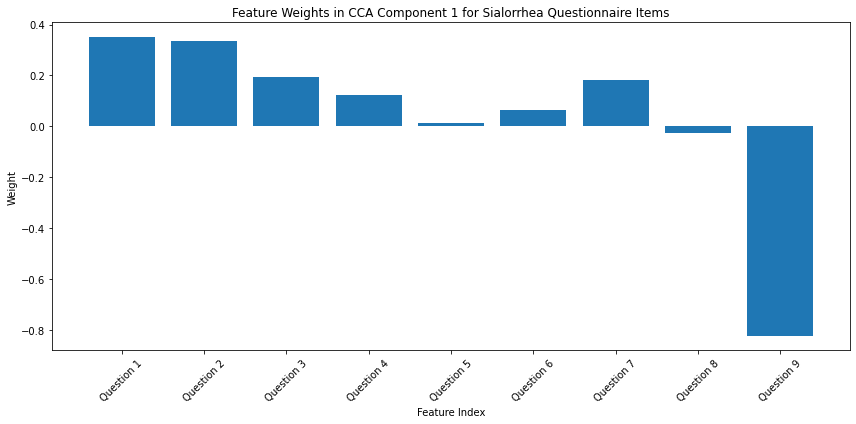

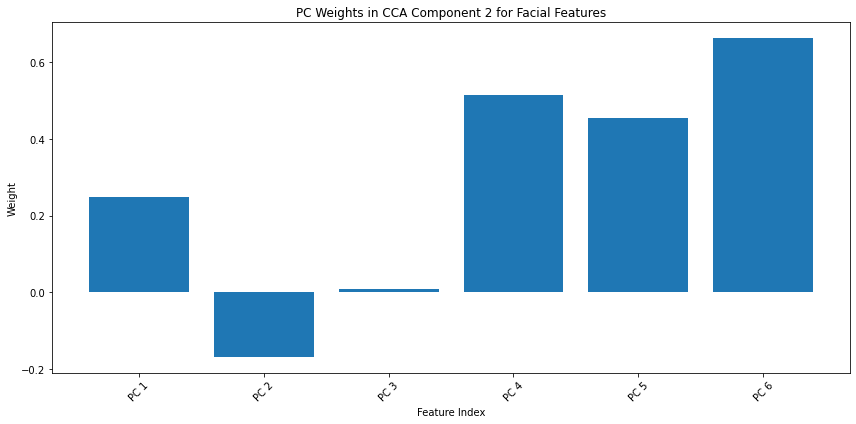

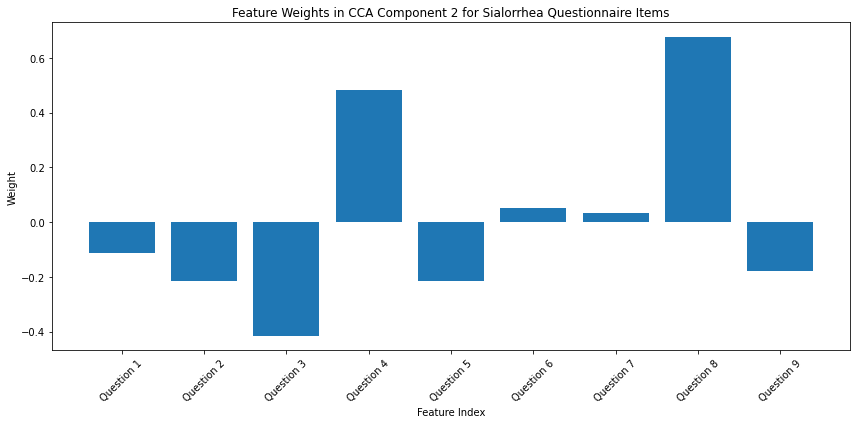

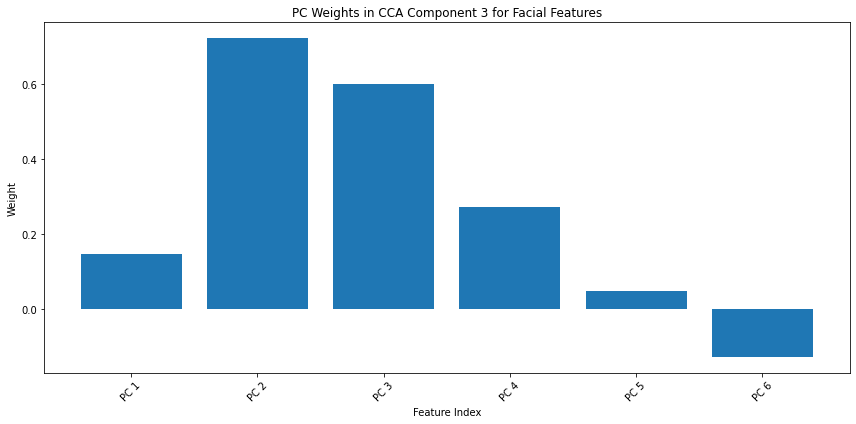

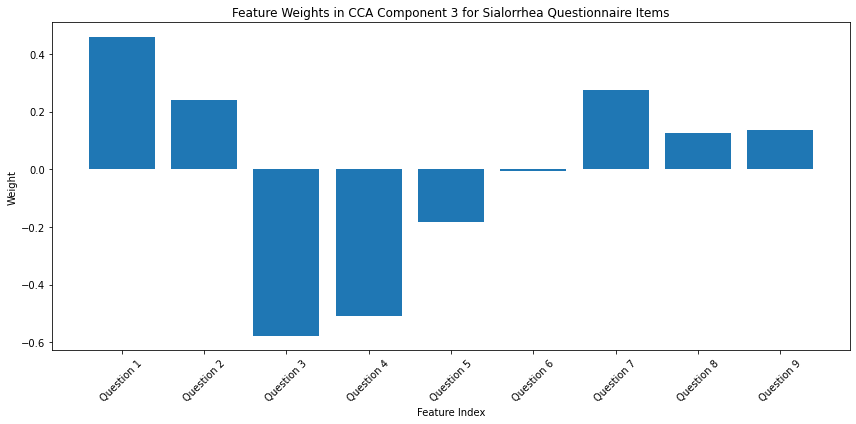

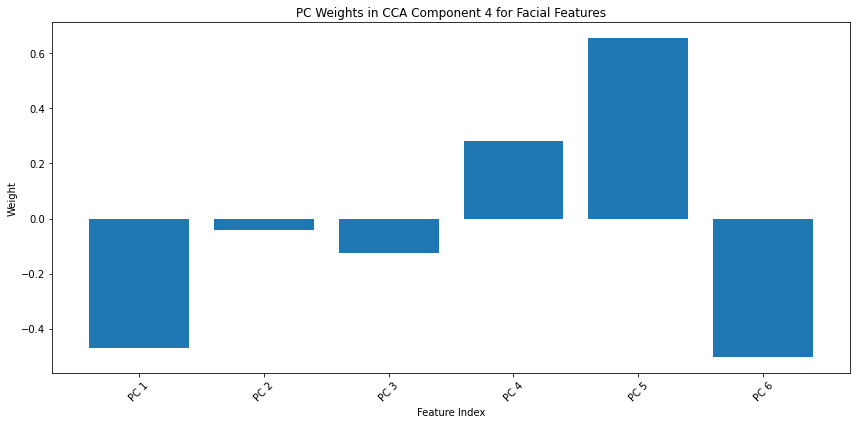

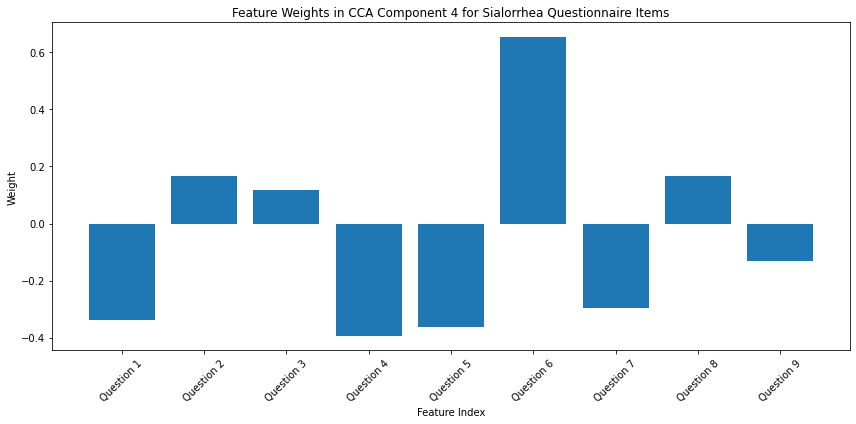

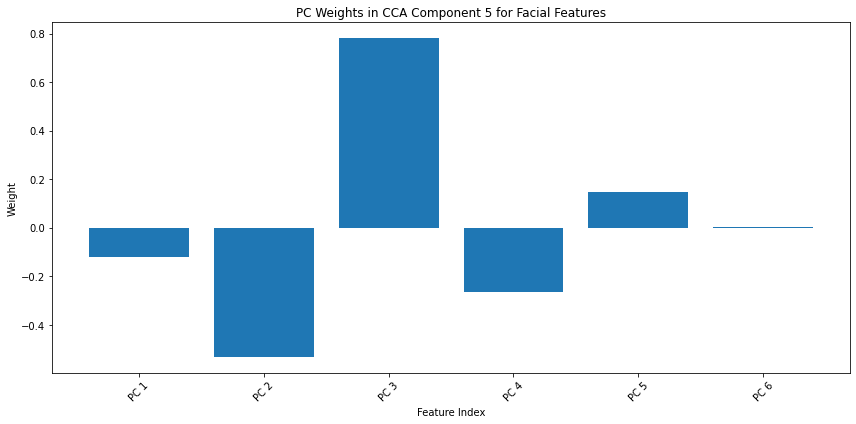

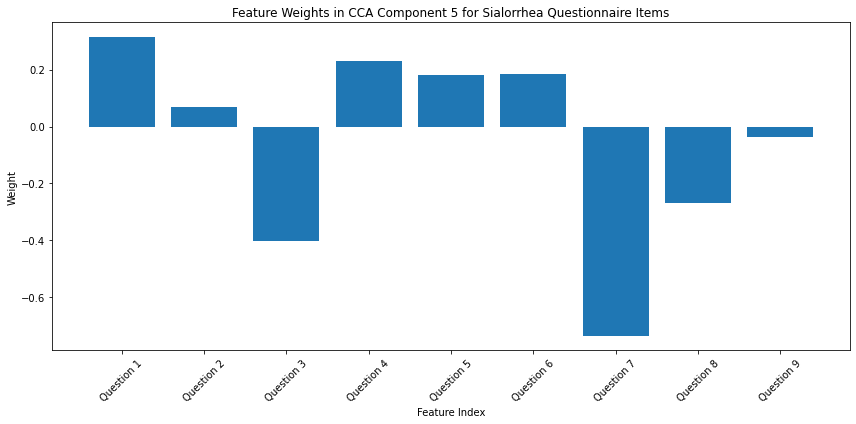

In [133]:
#print cca score
print(f'CCA Score: {cca.score( X_all, Y)}')
show_loadings(cca.x_loadings_, cca.y_loadings_)

#The left and right singular vectors of the cross-covariance matrices of X and Y
import matplotlib.pyplot as plt


for component_index in range(n_components_to_plot):
    # Extracting weights for the component
    weights_x = cca.x_weights_[:, component_index]
    weights_y = cca.y_weights_[:, component_index]

    # Plotting for X features
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(weights_x)), weights_x)
    plt.title(f'PC Weights in CCA Component {component_index+1} for Facial Features')
    plt.xlabel('Feature Index')
    plt.ylabel('Weight')
    plt.xticks(range(len(weights_x)), [f'PC {i+1}' for i in range(len(weights_x))], rotation=45)
    plt.tight_layout()
    plt.show()

    # Plotting for Y features
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(weights_y)), weights_y)
    plt.title(f'Feature Weights in CCA Component {component_index+1} for Sialorrhea Questionnaire Items')
    plt.xlabel('Feature Index')
    plt.ylabel('Weight')
    plt.xticks(range(len(weights_y)), [f'Question {i+1}' for i in range(len(weights_y))], rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# Creating a biplot
def biplot(score, coeff, labels=None):
    xs = score[:,0]
    ys = score[:,1]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    
    fig = plt.figure(figsize=(15, 15))
    plt.scatter(xs * scalex, ys * scaley)
    
    for i in range(len(coeff)):
        x, y = coeff[i,0], coeff[i,1]
        plt.plot([0, x], [0, y], 'r-')
        if labels is None:
            plt.text(x* 1.15, y * 1.15, "Var"+str(i+1), color='r')
        else:
            plt.text(x* 1.15, y * 1.15, labels[i], color='r')

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

# Call the biplot function
biplot(X_all, np.transpose(pca_all.components_),merged_all_df.columns[0:-10])
plt.show()
